In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
import pandas as pd

def SSDP_DDoS(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'BENING', r'DrDoS_SSDP']
    
    data = pd.read_csv('../NewDataset/output_file.csv', engine="python")

    data = data.replace("BENIGN", 0)
    data = data.replace("DDoS", 1)
    data = data[np.isfinite(data).all(1)]
    data = data.iloc[4000:5100]
    data = data[[" Flow Duration", " Average Packet Size", "Active Mean"," Label"]]    
    y = np.array(data[' Label'])
    data = data.drop(columns=[' Label'])
    x = StandardScaler().fit_transform(np.array(data))
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=109)
   
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
   
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_test[Y_test == k, :])[:test_size] for k, key in enumerate(class_labels)}
    
    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]
            label = 'DDoS' if k == 1 else 'BENIGN'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("DDoS_SSDP Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()
        

    return X_train, Y_train, X_test, Y_test, test_input, class_labels

In [3]:
import operator

def split_dataset_to_data_and_labels(dataset, class_names=None):
    data = []
    labels = []
    if class_names is None:
        sorted_classes_name = sorted(list(dataset.keys()))
        class_to_label = {k: idx for idx, k in enumerate(sorted_classes_name)}
    else:
        class_to_label = class_names
    sorted_label = sorted(class_to_label.items(), key=operator.itemgetter(1))
    for class_name, _ in sorted_label:
        values = dataset[class_name]
        for value in values:
            data.append(value)
            try:
                labels.append(class_to_label[class_name])
            except Exception as ex:  # pylint: disable=broad-except
                raise KeyError('The dataset has different class names to '
                               'the training data. error message: {}'.format(ex)) from ex
    data = np.asarray(data)
    labels = np.asarray(labels)
    if class_names is None:
        return [data, labels], class_to_label
    else:
        return [data, labels]

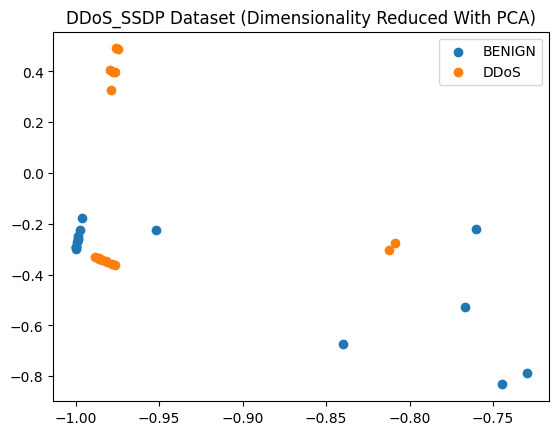

In [4]:
n = 3 # How many features to use (dimensionality)
training_dataset_size = int(20*0.8)
testing_dataset_size = int(20*0.2)

X_train, Y_train, X_test, Y_test, test_input, class_labels = SSDP_DDoS(training_dataset_size, testing_dataset_size, n)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)

In [5]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC

adhoc_feature_map = ZZFeatureMap(feature_dimension=3, reps=3, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

seed = 10598

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(X_train, Y_train)
adhoc_score_callable_function = adhoc_svc.score(X_test, Y_test)
print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

/tmp/ipykernel_130252/960988628.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.state_fidelities import ComputeUncompute


Callable kernel classification test score: 0.9916666666666667
